In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import time

In [ ]:
#create a model class
class Model(nn.Module):

  def __init__(self, in_tasks=9, in_stim=9, hidden=100, output=9, bias_weight=-2, coeff=0.3, thresh=0.0001):
    super().__init__()

    #Set Parameters
    self.bias_weight = bias_weight   # default bias weight
    self.coeff = coeff
    self.thresh = thresh

    self.task_hidden=nn.Linear(in_tasks, hidden)    #input layer(tasks) --> hidden layer
    self.stim_hidden=nn.Linear(in_stim, hidden)     #input layer(stimuls) --> hidden layer
    self.task_out=nn.Linear(in_tasks, output)       #Input Layer(tasks) --> output layer
    self.hidden_out=nn.Linear(hidden, output)       #hidden layer --> output layer

    self.task_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_tasks).uniform_(-0.1, 0.1))   #input(tasks)-->hidden  weight
    self.task_out.weight=nn.Parameter(torch.FloatTensor(output, in_tasks).uniform_(-0.1, 0.1))      #input(tasks) --> output weight
    self.stim_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_stim).uniform_(-0.1, 0.1))    #input(stimulus) -->hidden weight
    self.hidden_out.weight=nn.Parameter(torch.FloatTensor(output, hidden).uniform_(-0.1, 0.1))      #hidden-->output  weight

    #Check Sizes
    # print("Task Hidden Weight Shape:", self.task_hidden.weight.shape)
    # print("Task Output Weight Shape:", self.task_out.weight.shape)
    # print("Stimulus Hidden Weight Shape:", self.stim_hidden.weight.shape)
    # print("Hidden Output Weight Shape:", self.hidden_out.weight.shape)

    self.task_hidden.bias=nn.Parameter(torch.ones(hidden) * bias_weight)                   #hidden layer bias
    self.hidden_out.bias=nn.Parameter(torch.ones(output) * bias_weight)                    #output layer bias

  def forward(self, taskData, stimulusData):

    h_act=torch.sigmoid(self.task_hidden(taskData)+self.stim_hidden(stimulusData))   #hidden layer activation
    out_act= torch.sigmoid(self.hidden_out(h_act)+self.task_out(taskData))           #output layer activation

    return h_act, out_act


    #Check Sizes
    # print("h_act shape:", h_act.shape)
    # print("out_act shape:", out_act.shape)


In [ ]:
def plot_losses(losses, title):
   # plt.figure(figsize=(10, 6))  # Increase the figure size for better readability
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title(title)

    #plt.xticks(ticks=range(0, len(losses), max(1, len(losses) // 10)))
    plt.yticks(ticks=numpy.linspace(min(losses), max(losses), 10))
    plt.grid(True)
    plt.show()


In [ ]:
# Generate training data
def generate_dataset_singletask(split_ratio=None):

  #Generate Stimulus Data Pattern
  stimulusData = torch.tensor([ [0, 0, 1, 0, 0, 1, 0, 0, 1],
                                [0, 0, 1, 0, 0, 1, 0, 1, 0],
                                [0, 0, 1, 0, 0, 1, 1, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0, 1],
                                [0, 0, 1, 0, 1, 0, 0, 1, 0],
                                [0, 0, 1, 0, 1, 0, 1, 0, 0],
                                [0, 0, 1, 1, 0, 0, 0, 0, 1],
                                [0, 0, 1, 1, 0, 0, 0, 1, 0],
                                [0, 0, 1, 1, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 1, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 1, 0, 1, 0],
                                [0, 1, 0, 0, 0, 1, 1, 0, 0],
                                [0, 1, 0, 0, 1, 0, 0, 1, 0],
                                [0, 1, 0, 0, 1, 0, 1, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0, 1],
                                [0, 1, 0, 1, 0, 0, 0, 1, 0],
                                [0, 1, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 0, 1, 0, 0, 1],
                                [1, 0, 0, 0, 0, 1, 0, 1, 0],
                                [1, 0, 0, 0, 0, 1, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 1, 0],
                                [1, 0, 0, 0, 1, 0, 1, 0, 0]
                                                           ] *9 , dtype=torch.float)
   #Generate task data
  taskDatapattern = torch.tensor([
     [1, 0, 0, 0, 0, 0, 0, 0, 0] , #Task 1
     [0, 1, 0, 0, 0, 0, 0, 0, 0] , #Task 2
     [0, 0, 1, 0, 0, 0, 0, 0, 0] , #Task 3
     [0, 0, 0, 1, 0, 0, 0, 0, 0] , #Task 4
     [0, 0, 0, 0, 1, 0, 0, 0, 0] , #Task 5
     [0, 0, 0, 0, 0, 1, 0, 0, 0] , #Task 6
     [0, 0, 0, 0, 0, 0, 1, 0, 0] , #Task 7
     [0, 0, 0, 0, 0, 0, 0, 1, 0] , #Task 8
     [0, 0, 0, 0, 0, 0, 0, 0, 1] ]  #Task 9
                                 , dtype=torch.float)



  taskData = torch.cat([torch.stack([row] * 27) for row in taskDatapattern]) #Task data pattern repeated 27 times (27 is the number for stimulus data arrays)


 #Generate target data
  targetData = torch.zeros((243,9), dtype=torch.float)

  for i in range(len(targetData)):
     if taskData[i, :3].sum() > 0:
         targetData[i, :3] = stimulusData[i, :3]
     elif taskData[i, 3:6].sum() > 0:
         targetData[i, 3:6] = stimulusData[i, 3:6]
     elif taskData[i, 6:].sum() > 0:
         targetData[i, 6:] = stimulusData[i, 6:]


  # Split into training and validation sets
  dataset_size = len(stimulusData)
  split_index = int(split_ratio * dataset_size)  # Determine split index

  training_set = (stimulusData[:split_index], taskData[:split_index], targetData[:split_index])
  validation_set = (stimulusData[split_index:], taskData[split_index:], targetData[split_index:])

  return training_set, validation_set


In [ ]:
training_set, validation_set = generate_dataset_singletask(split_ratio=0.7)

In [ ]:
train_stimulus, train_task, train_target = training_set
stimulusData_V, taskData_V, targetData_V  = validation_set

In [ ]:
#create an instance for Model
model= Model()

In [ ]:
model(train_task, train_stimulus)

(tensor([[0.1497, 0.0943, 0.1433,  ..., 0.0945, 0.1399, 0.0891],
         [0.1467, 0.0977, 0.1456,  ..., 0.1067, 0.1249, 0.0999],
         [0.1548, 0.1054, 0.1359,  ..., 0.0952, 0.1393, 0.0987],
         ...,
         [0.1356, 0.1002, 0.1224,  ..., 0.0926, 0.1460, 0.1135],
         [0.1358, 0.0891, 0.1159,  ..., 0.0880, 0.1643, 0.1003],
         [0.1330, 0.0923, 0.1178,  ..., 0.0995, 0.1471, 0.1123]],
        grad_fn=<SigmoidBackward0>),
 tensor([[0.1266, 0.1233, 0.1125,  ..., 0.1312, 0.1090, 0.1447],
         [0.1259, 0.1236, 0.1129,  ..., 0.1311, 0.1081, 0.1445],
         [0.1259, 0.1237, 0.1129,  ..., 0.1310, 0.1084, 0.1450],
         ...,
         [0.1327, 0.1152, 0.1104,  ..., 0.1308, 0.0988, 0.1421],
         [0.1333, 0.1156, 0.1096,  ..., 0.1308, 0.0997, 0.1417],
         [0.1327, 0.1158, 0.1100,  ..., 0.1307, 0.0989, 0.1415]],
        grad_fn=<SigmoidBackward0>))

In [ ]:
#Check Data Sizes
print("Size of taskData:", train_task.size())
print("Size of stimulusData:", train_stimulus.size())
print("Size of trainData:", train_target.size())

print("Size of Validation Stimulus",stimulusData_V.shape)
print("Size of Validation Task",taskData_V.shape)
print("Size of Validation Target",targetData_V.shape)

Size of taskData: torch.Size([194, 9])
Size of stimulusData: torch.Size([194, 9])
Size of trainData: torch.Size([194, 9])
Size of Validation Stimulus torch.Size([49, 9])
Size of Validation Task torch.Size([49, 9])
Size of Validation Target torch.Size([49, 9])


In [ ]:
#Train Online Method using back propagation
def trainOnline(model, taskData, stimulusData, targetData, iterations, thresh=0.0001, lr=0.1):

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    MSE_log = []

    with tqdm(total=iterations) as pbar:

        for i in range(iterations):
            optimizer.zero_grad()
            h_act, out_act = model(taskData, stimulusData)
            loss = criterion(out_act, targetData)
            loss.backward()
            optimizer.step()
            MSE = loss.item()
            MSE_log.append(MSE)

            if MSE < thresh:
                break


            pbar.set_postfix({'MSE': MSE})
            pbar.update(1)

    return MSE_log


In [ ]:
#Backpropagation learning
iterations = 200000
MSE_log = trainOnline(model, train_stimulus, train_task, train_target, iterations)

100%|██████████| 200000/200000 [19:38<00:00, 169.64it/s, MSE=0.00194]


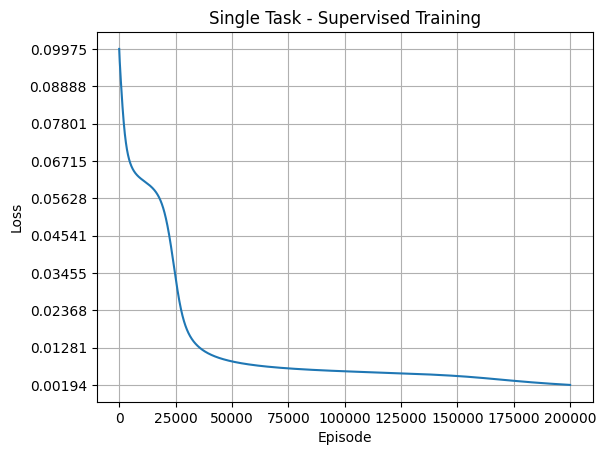

In [ ]:
single_log=plot_losses(MSE_log, "Single Task - Supervised Training")

In [ ]:
#Re-create an instance for Model to reset the parameters
model= Model()

In [ ]:
model(train_task, train_stimulus)

In [ ]:
#Reinforcement learning using REINFORCE algorithm
def reinforce_train(model, optimizer, taskData, stimulusData, reward):

    optimizer.zero_grad()

    _, outputs = model(taskData, stimulusData)
    log_probs = torch.log(outputs.squeeze(0))

    # REINFORCE loss
    loss = -log_probs * reward
    loss = loss.mean()
    #reward = torch.sum(outputs * targetData)
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
#Reinforce traning Loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Define the Optimizer
# Define training loop
def train_Rein(model, optimizer, train_task, train_stimulus, train_target, num_episodes=1000, log_interval=1):
    losses = []  # To store losses at each episode
    for episode in range(1, num_episodes + 1):

        # Forward pass
        _, outputs = model(train_task, train_stimulus)

        # Define reward
        reward = torch.sum(outputs * train_target)

        # Train using REINFORCE
        loss = reinforce_train(model, optimizer, train_task, train_stimulus, reward)
        losses.append(loss)
        #Logging
        if episode % log_interval == 0:
            print(f"Episode {episode}/{num_episodes} | Loss: {loss:.3f}")
    return losses

In [ ]:
losses=train_Rein(model, optimizer, train_task, train_stimulus, train_target, num_episodes=1000, log_interval=1)

Episode 1/1000 | Loss: 42.327
Episode 2/1000 | Loss: 41.850
Episode 3/1000 | Loss: 41.380
Episode 4/1000 | Loss: 40.916
Episode 5/1000 | Loss: 40.457
Episode 6/1000 | Loss: 40.005
Episode 7/1000 | Loss: 39.558
Episode 8/1000 | Loss: 39.117
Episode 9/1000 | Loss: 38.681
Episode 10/1000 | Loss: 38.252
Episode 11/1000 | Loss: 37.827
Episode 12/1000 | Loss: 37.408
Episode 13/1000 | Loss: 36.995
Episode 14/1000 | Loss: 36.586
Episode 15/1000 | Loss: 36.183
Episode 16/1000 | Loss: 35.785
Episode 17/1000 | Loss: 35.392
Episode 18/1000 | Loss: 35.004
Episode 19/1000 | Loss: 34.620
Episode 20/1000 | Loss: 34.242
Episode 21/1000 | Loss: 33.868
Episode 22/1000 | Loss: 33.499
Episode 23/1000 | Loss: 33.134
Episode 24/1000 | Loss: 32.774
Episode 25/1000 | Loss: 32.419
Episode 26/1000 | Loss: 32.067
Episode 27/1000 | Loss: 31.720
Episode 28/1000 | Loss: 31.377
Episode 29/1000 | Loss: 31.038
Episode 30/1000 | Loss: 30.703
Episode 31/1000 | Loss: 30.371
Episode 32/1000 | Loss: 30.044
Episode 33/1000 |

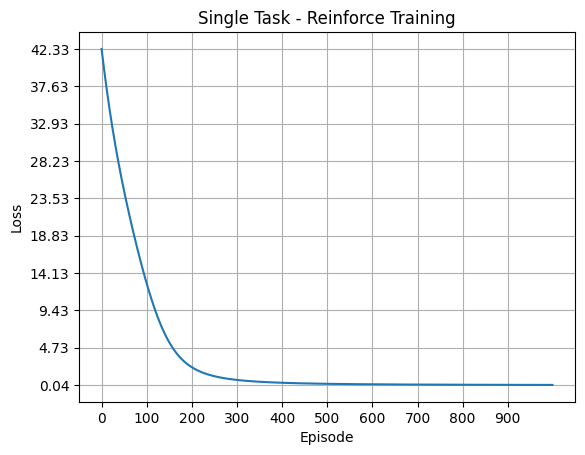

In [ ]:
Reinforce_log= plot_losses(losses, "Single Task - Reinforce Training")

In [ ]:
#Define Evalutae function
def evaluate(model, taskData, stimulusData, targetData):
    model.eval()
    with torch.no_grad():
        _, val_output = model(taskData, stimulusData)
        criterion = nn.MSELoss()
        val_loss = criterion(val_output, targetData).item()
    model.train()
    return val_loss

In [ ]:
evaluate(model, taskData_V, stimulusData_V, targetData_V)

0.1110457330942154

In [ ]:
#Define multiple simulations
def run_simulations(n_simulations=100, num_episodes=1000, log_interval=100):
    all_losses = []

    for i in tqdm(range(n_simulations)):
        model = Model()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        training_set, validation_set = generate_dataset_singletask(split_ratio=0.7)
        train_stimulus, train_task, train_target = training_set

        losses = train_Rein(model, optimizer, train_task, train_stimulus, train_target, num_episodes, log_interval)

        if len(losses) > 0:
            print(f"Simulation {i+1}: First few losses: {losses[:5]}")

        all_losses.append(losses)

    print(f"Total simulations run: {len(all_losses)}")
    return all_losses

In [ ]:
def calculate_mean_and_standard_error(losses):
    min_length = min(len(loss) for loss in losses)
    trimmed_losses = [loss[:min_length] for loss in losses if loss is not None]  # Exclude None losses
    losses_array = numpy.array(trimmed_losses) # convert to numpy array
    mean_losses = numpy.mean(losses_array, axis=0)  #calculate mean
    std_err_losses = numpy.std(losses_array, axis=0) / numpy.sqrt(losses_array.shape[0]) #calculate standard deviation
    return mean_losses, std_err_losses

In [ ]:
def plot_learning_curve_with_standard_error(mean_losses, std_err_losses, title):
    epochs = range(len(mean_losses))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_losses, label='Mean Loss', linewidth=2)
    # Scaling the standard error for visibility; here we multiply by 10 for example purposes
    visible_std_err_losses = std_err_losses * 100
    plt.fill_between(epochs, mean_losses - visible_std_err_losses, mean_losses + visible_std_err_losses, color='b', alpha=0.3, label='Standard Error (Scaled)')
    plt.xlabel('Epochs / Episodes')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_").lower()}_learning_curve_with_standard_error.png')
    plt.show()


In [ ]:
all_losses = run_simulations(n_simulations=100, num_episodes=1000, log_interval=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Episode 100/1000 | Loss: 12.738
Episode 200/1000 | Loss: 2.303
Episode 300/1000 | Loss: 0.667
Episode 400/1000 | Loss: 0.305
Episode 500/1000 | Loss: 0.174
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.045


  1%|          | 1/100 [00:02<04:11,  2.54s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 1: First few losses: [41.957820892333984, 41.481571197509766, 41.01091384887695, 40.54585266113281, 40.086341857910156]
Episode 100/1000 | Loss: 11.982
Episode 200/1000 | Loss: 2.125
Episode 300/1000 | Loss: 0.621
Episode 400/1000 | Loss: 0.285
Episode 500/1000 | Loss: 0.163
Episode 600/1000 | Loss: 0.105
Episode 700/1000 | Loss: 0.074
Episode 800/1000 | Loss: 0.055
Episode 900/1000 | Loss: 0.042


  2%|▏         | 2/100 [00:05<04:34,  2.81s/it]

Episode 1000/1000 | Loss: 0.033
Simulation 2: First few losses: [38.72168731689453, 38.28701400756836, 37.85784149169922, 37.434165954589844, 37.01593017578125]
Episode 100/1000 | Loss: 13.234
Episode 200/1000 | Loss: 2.300
Episode 300/1000 | Loss: 0.663
Episode 400/1000 | Loss: 0.303
Episode 500/1000 | Loss: 0.173
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.044


  3%|▎         | 3/100 [00:08<04:33,  2.82s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 3: First few losses: [42.709598541259766, 42.237144470214844, 41.77045440673828, 41.30948257446289, 40.854190826416016]
Episode 100/1000 | Loss: 13.723
Episode 200/1000 | Loss: 2.436
Episode 300/1000 | Loss: 0.694
Episode 400/1000 | Loss: 0.316
Episode 500/1000 | Loss: 0.180
Episode 600/1000 | Loss: 0.116
Episode 700/1000 | Loss: 0.081
Episode 800/1000 | Loss: 0.060
Episode 900/1000 | Loss: 0.046


  4%|▍         | 4/100 [00:10<04:15,  2.66s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 4: First few losses: [43.088165283203125, 42.622276306152344, 42.161922454833984, 41.707061767578125, 41.25762939453125]
Episode 100/1000 | Loss: 13.892
Episode 200/1000 | Loss: 2.384
Episode 300/1000 | Loss: 0.679
Episode 400/1000 | Loss: 0.310
Episode 500/1000 | Loss: 0.177
Episode 600/1000 | Loss: 0.115
Episode 700/1000 | Loss: 0.080
Episode 800/1000 | Loss: 0.059
Episode 900/1000 | Loss: 0.046


  5%|▌         | 5/100 [00:13<04:05,  2.58s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 5: First few losses: [44.07483673095703, 43.59265899658203, 43.11664962768555, 42.64677810668945, 42.1829719543457]
Episode 100/1000 | Loss: 14.364
Episode 200/1000 | Loss: 2.819
Episode 300/1000 | Loss: 0.774
Episode 400/1000 | Loss: 0.341
Episode 500/1000 | Loss: 0.191
Episode 600/1000 | Loss: 0.122
Episode 700/1000 | Loss: 0.085
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.047


  6%|▌         | 6/100 [00:15<03:58,  2.54s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 6: First few losses: [44.87071990966797, 44.374114990234375, 43.883811950683594, 43.399784088134766, 42.92195510864258]
Episode 100/1000 | Loss: 12.515
Episode 200/1000 | Loss: 2.214
Episode 300/1000 | Loss: 0.651
Episode 400/1000 | Loss: 0.300
Episode 500/1000 | Loss: 0.172
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.045


  7%|▋         | 7/100 [00:18<04:17,  2.77s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 7: First few losses: [41.751747131347656, 41.27202224731445, 40.79830551147461, 40.330535888671875, 39.868690490722656]
Episode 100/1000 | Loss: 12.483
Episode 200/1000 | Loss: 2.206
Episode 300/1000 | Loss: 0.651
Episode 400/1000 | Loss: 0.301
Episode 500/1000 | Loss: 0.173
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.079
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.045


  8%|▊         | 8/100 [00:21<04:17,  2.80s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 8: First few losses: [41.615684509277344, 41.14161682128906, 40.67312240600586, 40.210208892822266, 39.75286865234375]
Episode 100/1000 | Loss: 14.384
Episode 200/1000 | Loss: 2.556
Episode 300/1000 | Loss: 0.716
Episode 400/1000 | Loss: 0.323
Episode 500/1000 | Loss: 0.184
Episode 600/1000 | Loss: 0.119
Episode 700/1000 | Loss: 0.083
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


  9%|▉         | 9/100 [00:24<04:07,  2.72s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 9: First few losses: [45.245853424072266, 44.7539176940918, 44.26783752441406, 43.787601470947266, 43.31315994262695]
Episode 100/1000 | Loss: 12.722
Episode 200/1000 | Loss: 2.159
Episode 300/1000 | Loss: 0.635
Episode 400/1000 | Loss: 0.293
Episode 500/1000 | Loss: 0.168
Episode 600/1000 | Loss: 0.109
Episode 700/1000 | Loss: 0.077
Episode 800/1000 | Loss: 0.057
Episode 900/1000 | Loss: 0.044


 10%|█         | 10/100 [00:26<04:00,  2.67s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 10: First few losses: [41.78582000732422, 41.3258056640625, 40.871761322021484, 40.42366027832031, 39.98148727416992]
Episode 100/1000 | Loss: 15.243
Episode 200/1000 | Loss: 3.220
Episode 300/1000 | Loss: 0.880
Episode 400/1000 | Loss: 0.383
Episode 500/1000 | Loss: 0.213
Episode 600/1000 | Loss: 0.136
Episode 700/1000 | Loss: 0.094
Episode 800/1000 | Loss: 0.069
Episode 900/1000 | Loss: 0.053


 11%|█         | 11/100 [00:29<03:54,  2.64s/it]

Episode 1000/1000 | Loss: 0.042
Simulation 11: First few losses: [48.05319595336914, 47.51155471801758, 46.97636795043945, 46.44757843017578, 45.925174713134766]
Episode 100/1000 | Loss: 14.208
Episode 200/1000 | Loss: 2.615
Episode 300/1000 | Loss: 0.736
Episode 400/1000 | Loss: 0.331
Episode 500/1000 | Loss: 0.188
Episode 600/1000 | Loss: 0.121
Episode 700/1000 | Loss: 0.084
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.048


 12%|█▏        | 12/100 [00:32<04:15,  2.90s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 12: First few losses: [45.55503845214844, 45.04974365234375, 44.550601959228516, 44.057594299316406, 43.57068634033203]
Episode 100/1000 | Loss: 10.278
Episode 200/1000 | Loss: 1.730
Episode 300/1000 | Loss: 0.540
Episode 400/1000 | Loss: 0.256
Episode 500/1000 | Loss: 0.149
Episode 600/1000 | Loss: 0.097
Episode 700/1000 | Loss: 0.069
Episode 800/1000 | Loss: 0.051
Episode 900/1000 | Loss: 0.039


 13%|█▎        | 13/100 [00:35<04:00,  2.76s/it]

Episode 1000/1000 | Loss: 0.031
Simulation 13: First few losses: [36.67099380493164, 36.25169372558594, 35.83757781982422, 35.428646087646484, 35.02488327026367]
Episode 100/1000 | Loss: 13.282
Episode 200/1000 | Loss: 2.455
Episode 300/1000 | Loss: 0.713
Episode 400/1000 | Loss: 0.325
Episode 500/1000 | Loss: 0.185
Episode 600/1000 | Loss: 0.119
Episode 700/1000 | Loss: 0.083
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.047


 14%|█▍        | 14/100 [00:37<03:52,  2.70s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 14: First few losses: [43.31511306762695, 42.8245964050293, 42.34008026123047, 41.861534118652344, 41.388916015625]
Episode 100/1000 | Loss: 13.024
Episode 200/1000 | Loss: 2.353
Episode 300/1000 | Loss: 0.675
Episode 400/1000 | Loss: 0.306
Episode 500/1000 | Loss: 0.174
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.044


 15%|█▌        | 15/100 [00:40<03:46,  2.66s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 15: First few losses: [41.61530303955078, 41.1522216796875, 40.69505310058594, 40.2437744140625, 39.79834747314453]
Episode 100/1000 | Loss: 12.606
Episode 200/1000 | Loss: 2.230
Episode 300/1000 | Loss: 0.651
Episode 400/1000 | Loss: 0.299
Episode 500/1000 | Loss: 0.171
Episode 600/1000 | Loss: 0.111
Episode 700/1000 | Loss: 0.077
Episode 800/1000 | Loss: 0.057
Episode 900/1000 | Loss: 0.044


 16%|█▌        | 16/100 [00:43<03:41,  2.63s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 16: First few losses: [40.80181884765625, 40.344627380371094, 39.893253326416016, 39.44767379760742, 39.007850646972656]
Episode 100/1000 | Loss: 13.012
Episode 200/1000 | Loss: 2.340
Episode 300/1000 | Loss: 0.681
Episode 400/1000 | Loss: 0.312
Episode 500/1000 | Loss: 0.178
Episode 600/1000 | Loss: 0.115
Episode 700/1000 | Loss: 0.081
Episode 800/1000 | Loss: 0.060
Episode 900/1000 | Loss: 0.046


 17%|█▋        | 17/100 [00:46<04:01,  2.91s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 17: First few losses: [42.81733703613281, 42.334022521972656, 41.85647201538086, 41.384647369384766, 40.918487548828125]
Episode 100/1000 | Loss: 14.815
Episode 200/1000 | Loss: 2.938
Episode 300/1000 | Loss: 0.802
Episode 400/1000 | Loss: 0.353
Episode 500/1000 | Loss: 0.197
Episode 600/1000 | Loss: 0.126
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.064
Episode 900/1000 | Loss: 0.049


 18%|█▊        | 18/100 [00:49<03:51,  2.83s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 18: First few losses: [45.81031036376953, 45.2955207824707, 44.78744888305664, 44.28607940673828, 43.791324615478516]
Episode 100/1000 | Loss: 13.590
Episode 200/1000 | Loss: 2.397
Episode 300/1000 | Loss: 0.686
Episode 400/1000 | Loss: 0.312
Episode 500/1000 | Loss: 0.178
Episode 600/1000 | Loss: 0.115
Episode 700/1000 | Loss: 0.080
Episode 800/1000 | Loss: 0.059
Episode 900/1000 | Loss: 0.046


 19%|█▉        | 19/100 [00:51<03:44,  2.77s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 19: First few losses: [42.83815002441406, 42.35926818847656, 41.88664627075195, 41.42026138305664, 40.96007537841797]
Episode 100/1000 | Loss: 13.644
Episode 200/1000 | Loss: 2.638
Episode 300/1000 | Loss: 0.763
Episode 400/1000 | Loss: 0.345
Episode 500/1000 | Loss: 0.196
Episode 600/1000 | Loss: 0.126
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 20%|██        | 20/100 [00:54<03:36,  2.70s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 20: First few losses: [45.62449264526367, 45.10305404663086, 44.58750534057617, 44.07782745361328, 43.573997497558594]
Episode 100/1000 | Loss: 14.499
Episode 200/1000 | Loss: 2.851
Episode 300/1000 | Loss: 0.791
Episode 400/1000 | Loss: 0.350
Episode 500/1000 | Loss: 0.196
Episode 600/1000 | Loss: 0.125
Episode 700/1000 | Loss: 0.087
Episode 800/1000 | Loss: 0.064
Episode 900/1000 | Loss: 0.049


 21%|██        | 21/100 [00:57<03:37,  2.75s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 21: First few losses: [46.0266227722168, 45.52118682861328, 45.0213508605957, 44.52714538574219, 44.038516998291016]
Episode 100/1000 | Loss: 14.290
Episode 200/1000 | Loss: 2.811
Episode 300/1000 | Loss: 0.791
Episode 400/1000 | Loss: 0.352
Episode 500/1000 | Loss: 0.198
Episode 600/1000 | Loss: 0.127
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 22%|██▏       | 22/100 [01:00<03:47,  2.92s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 22: First few losses: [45.69110107421875, 45.172691345214844, 44.660614013671875, 44.15480041503906, 43.65513610839844]
Episode 100/1000 | Loss: 12.972
Episode 200/1000 | Loss: 2.467
Episode 300/1000 | Loss: 0.722
Episode 400/1000 | Loss: 0.329
Episode 500/1000 | Loss: 0.187
Episode 600/1000 | Loss: 0.120
Episode 700/1000 | Loss: 0.084
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.048


 23%|██▎       | 23/100 [01:03<03:42,  2.89s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 23: First few losses: [43.71232986450195, 43.20813751220703, 42.709877014160156, 42.21750259399414, 41.73097610473633]
Episode 100/1000 | Loss: 14.124
Episode 200/1000 | Loss: 2.707
Episode 300/1000 | Loss: 0.753
Episode 400/1000 | Loss: 0.336
Episode 500/1000 | Loss: 0.190
Episode 600/1000 | Loss: 0.122
Episode 700/1000 | Loss: 0.085
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.048


 24%|██▍       | 24/100 [01:06<03:31,  2.79s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 24: First few losses: [44.338111877441406, 43.845619201660156, 43.359046936035156, 42.87839126586914, 42.40360641479492]
Episode 100/1000 | Loss: 14.195
Episode 200/1000 | Loss: 2.714
Episode 300/1000 | Loss: 0.772
Episode 400/1000 | Loss: 0.347
Episode 500/1000 | Loss: 0.196
Episode 600/1000 | Loss: 0.126
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.064
Episode 900/1000 | Loss: 0.049


 25%|██▌       | 25/100 [01:08<03:23,  2.72s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 25: First few losses: [45.8879508972168, 45.372615814208984, 44.86335754394531, 44.36020278930664, 43.86310577392578]
Episode 100/1000 | Loss: 13.056
Episode 200/1000 | Loss: 2.517
Episode 300/1000 | Loss: 0.734
Episode 400/1000 | Loss: 0.333
Episode 500/1000 | Loss: 0.190
Episode 600/1000 | Loss: 0.122
Episode 700/1000 | Loss: 0.085
Episode 800/1000 | Loss: 0.063
Episode 900/1000 | Loss: 0.048


 26%|██▌       | 26/100 [01:12<03:47,  3.07s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 26: First few losses: [43.9555778503418, 43.44319152832031, 42.937034606933594, 42.43706130981445, 41.94322204589844]
Episode 100/1000 | Loss: 12.183
Episode 200/1000 | Loss: 2.108
Episode 300/1000 | Loss: 0.623
Episode 400/1000 | Loss: 0.288
Episode 500/1000 | Loss: 0.165
Episode 600/1000 | Loss: 0.107
Episode 700/1000 | Loss: 0.075
Episode 800/1000 | Loss: 0.056
Episode 900/1000 | Loss: 0.043


 27%|██▋       | 27/100 [01:15<03:37,  2.98s/it]

Episode 1000/1000 | Loss: 0.034
Simulation 27: First few losses: [40.03929901123047, 39.58676528930664, 39.13991165161133, 38.6987419128418, 38.263221740722656]
Episode 100/1000 | Loss: 15.235
Episode 200/1000 | Loss: 2.984
Episode 300/1000 | Loss: 0.819
Episode 400/1000 | Loss: 0.361
Episode 500/1000 | Loss: 0.202
Episode 600/1000 | Loss: 0.129
Episode 700/1000 | Loss: 0.090
Episode 800/1000 | Loss: 0.066
Episode 900/1000 | Loss: 0.051


 28%|██▊       | 28/100 [01:17<03:25,  2.85s/it]

Episode 1000/1000 | Loss: 0.040
Simulation 28: First few losses: [47.320579528808594, 46.8127555847168, 46.310951232910156, 45.81512451171875, 45.3251953125]
Episode 100/1000 | Loss: 12.474
Episode 200/1000 | Loss: 2.183
Episode 300/1000 | Loss: 0.651
Episode 400/1000 | Loss: 0.302
Episode 500/1000 | Loss: 0.174
Episode 600/1000 | Loss: 0.113
Episode 700/1000 | Loss: 0.079
Episode 800/1000 | Loss: 0.059
Episode 900/1000 | Loss: 0.045


 29%|██▉       | 29/100 [01:20<03:18,  2.79s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 29: First few losses: [41.70000076293945, 41.210426330566406, 40.727176666259766, 40.250240325927734, 39.77960968017578]
Episode 100/1000 | Loss: 14.012
Episode 200/1000 | Loss: 2.747
Episode 300/1000 | Loss: 0.777
Episode 400/1000 | Loss: 0.347
Episode 500/1000 | Loss: 0.196
Episode 600/1000 | Loss: 0.126
Episode 700/1000 | Loss: 0.087
Episode 800/1000 | Loss: 0.064
Episode 900/1000 | Loss: 0.049


 30%|███       | 30/100 [01:23<03:17,  2.82s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 30: First few losses: [45.352603912353516, 44.835208892822266, 44.32423782348633, 43.81966781616211, 43.32148742675781]
Episode 100/1000 | Loss: 15.000
Episode 200/1000 | Loss: 2.866
Episode 300/1000 | Loss: 0.791
Episode 400/1000 | Loss: 0.352
Episode 500/1000 | Loss: 0.198
Episode 600/1000 | Loss: 0.127
Episode 700/1000 | Loss: 0.089
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 31%|███       | 31/100 [01:26<03:23,  2.96s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 31: First few losses: [46.947731018066406, 46.43027877807617, 45.919105529785156, 45.41416931152344, 44.9154167175293]
Episode 100/1000 | Loss: 14.541
Episode 200/1000 | Loss: 2.617
Episode 300/1000 | Loss: 0.736
Episode 400/1000 | Loss: 0.333
Episode 500/1000 | Loss: 0.189
Episode 600/1000 | Loss: 0.122
Episode 700/1000 | Loss: 0.085
Episode 800/1000 | Loss: 0.063
Episode 900/1000 | Loss: 0.048


 32%|███▏      | 32/100 [01:29<03:10,  2.81s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 32: First few losses: [45.64514923095703, 45.13825225830078, 44.63772964477539, 44.14356994628906, 43.655723571777344]
Episode 100/1000 | Loss: 12.097
Episode 200/1000 | Loss: 2.132
Episode 300/1000 | Loss: 0.629
Episode 400/1000 | Loss: 0.289
Episode 500/1000 | Loss: 0.166
Episode 600/1000 | Loss: 0.107
Episode 700/1000 | Loss: 0.075
Episode 800/1000 | Loss: 0.055
Episode 900/1000 | Loss: 0.043


 33%|███▎      | 33/100 [01:31<03:01,  2.71s/it]

Episode 1000/1000 | Loss: 0.034
Simulation 33: First few losses: [39.560386657714844, 39.109493255615234, 38.66481399536133, 38.226314544677734, 37.79393768310547]
Episode 100/1000 | Loss: 13.357
Episode 200/1000 | Loss: 2.469
Episode 300/1000 | Loss: 0.717
Episode 400/1000 | Loss: 0.327
Episode 500/1000 | Loss: 0.186
Episode 600/1000 | Loss: 0.120
Episode 700/1000 | Loss: 0.084
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.048


 34%|███▍      | 34/100 [01:34<02:54,  2.64s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 34: First few losses: [44.0402946472168, 43.5436897277832, 43.0527458190918, 42.56745910644531, 42.08779525756836]
Episode 100/1000 | Loss: 13.767
Episode 200/1000 | Loss: 2.430
Episode 300/1000 | Loss: 0.693
Episode 400/1000 | Loss: 0.315
Episode 500/1000 | Loss: 0.180
Episode 600/1000 | Loss: 0.116
Episode 700/1000 | Loss: 0.081
Episode 800/1000 | Loss: 0.060
Episode 900/1000 | Loss: 0.046


 35%|███▌      | 35/100 [01:36<02:56,  2.71s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 35: First few losses: [44.417240142822266, 43.92401885986328, 43.43684768676758, 42.955684661865234, 42.480525970458984]
Episode 100/1000 | Loss: 13.639
Episode 200/1000 | Loss: 2.625
Episode 300/1000 | Loss: 0.745
Episode 400/1000 | Loss: 0.334
Episode 500/1000 | Loss: 0.189
Episode 600/1000 | Loss: 0.121
Episode 700/1000 | Loss: 0.085
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.048


 36%|███▌      | 36/100 [01:40<03:01,  2.84s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 36: First few losses: [44.05154037475586, 43.555938720703125, 43.06581497192383, 42.58116912841797, 42.102020263671875]
Episode 100/1000 | Loss: 13.779
Episode 200/1000 | Loss: 2.534
Episode 300/1000 | Loss: 0.721
Episode 400/1000 | Loss: 0.326
Episode 500/1000 | Loss: 0.185
Episode 600/1000 | Loss: 0.119
Episode 700/1000 | Loss: 0.083
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


 37%|███▋      | 37/100 [01:42<02:52,  2.74s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 37: First few losses: [43.87335968017578, 43.370689392089844, 42.87483596801758, 42.385772705078125, 41.90343475341797]
Episode 100/1000 | Loss: 15.295
Episode 200/1000 | Loss: 3.010
Episode 300/1000 | Loss: 0.811
Episode 400/1000 | Loss: 0.356
Episode 500/1000 | Loss: 0.199
Episode 600/1000 | Loss: 0.127
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 38%|███▊      | 38/100 [01:45<02:44,  2.65s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 38: First few losses: [46.05684280395508, 45.54332733154297, 45.03653335571289, 44.536502838134766, 44.043212890625]
Episode 100/1000 | Loss: 15.155
Episode 200/1000 | Loss: 2.867
Episode 300/1000 | Loss: 0.793
Episode 400/1000 | Loss: 0.353
Episode 500/1000 | Loss: 0.199
Episode 600/1000 | Loss: 0.128
Episode 700/1000 | Loss: 0.089
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 39%|███▉      | 39/100 [01:47<02:39,  2.62s/it]

Episode 1000/1000 | Loss: 0.040
Simulation 39: First few losses: [47.0508918762207, 46.53184127807617, 46.01930618286133, 45.51323699951172, 45.013572692871094]
Episode 100/1000 | Loss: 13.837
Episode 200/1000 | Loss: 2.550
Episode 300/1000 | Loss: 0.722
Episode 400/1000 | Loss: 0.325
Episode 500/1000 | Loss: 0.184
Episode 600/1000 | Loss: 0.118
Episode 700/1000 | Loss: 0.082
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


 40%|████      | 40/100 [01:50<02:48,  2.81s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 40: First few losses: [44.858699798583984, 44.36320495605469, 43.87388229370117, 43.390716552734375, 42.91363525390625]
Episode 100/1000 | Loss: 12.687
Episode 200/1000 | Loss: 2.418
Episode 300/1000 | Loss: 0.706
Episode 400/1000 | Loss: 0.322
Episode 500/1000 | Loss: 0.183
Episode 600/1000 | Loss: 0.118
Episode 700/1000 | Loss: 0.083
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


 41%|████      | 41/100 [01:53<02:46,  2.81s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 41: First few losses: [43.136009216308594, 42.624820709228516, 42.12010955810547, 41.621856689453125, 41.130035400390625]
Episode 100/1000 | Loss: 13.214
Episode 200/1000 | Loss: 2.458
Episode 300/1000 | Loss: 0.711
Episode 400/1000 | Loss: 0.323
Episode 500/1000 | Loss: 0.184
Episode 600/1000 | Loss: 0.119
Episode 700/1000 | Loss: 0.083
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


 42%|████▏     | 42/100 [01:57<03:07,  3.23s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 42: First few losses: [43.56107711791992, 43.0646858215332, 42.57402801513672, 42.08909225463867, 41.60979461669922]
Episode 100/1000 | Loss: 14.487
Episode 200/1000 | Loss: 2.800
Episode 300/1000 | Loss: 0.787
Episode 400/1000 | Loss: 0.351
Episode 500/1000 | Loss: 0.198
Episode 600/1000 | Loss: 0.127
Episode 700/1000 | Loss: 0.089
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 43%|████▎     | 43/100 [02:00<03:00,  3.17s/it]

Episode 1000/1000 | Loss: 0.040
Simulation 43: First few losses: [47.034698486328125, 46.50628662109375, 45.98408508300781, 45.46809005737305, 44.95827102661133]
Episode 100/1000 | Loss: 13.307
Episode 200/1000 | Loss: 2.535
Episode 300/1000 | Loss: 0.728
Episode 400/1000 | Loss: 0.329
Episode 500/1000 | Loss: 0.187
Episode 600/1000 | Loss: 0.120
Episode 700/1000 | Loss: 0.084
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.047


 44%|████▍     | 44/100 [02:04<03:10,  3.40s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 44: First few losses: [43.957801818847656, 43.45131301879883, 42.950721740722656, 42.45599365234375, 41.96710968017578]
Episode 100/1000 | Loss: 13.194
Episode 200/1000 | Loss: 2.250
Episode 300/1000 | Loss: 0.654
Episode 400/1000 | Loss: 0.301
Episode 500/1000 | Loss: 0.173
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.079
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.045


 45%|████▌     | 45/100 [02:07<02:55,  3.19s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 45: First few losses: [42.855648040771484, 42.379886627197266, 41.90995788574219, 41.445858001708984, 40.98758316040039]
Episode 100/1000 | Loss: 13.440
Episode 200/1000 | Loss: 2.374
Episode 300/1000 | Loss: 0.677
Episode 400/1000 | Loss: 0.308
Episode 500/1000 | Loss: 0.175
Episode 600/1000 | Loss: 0.113
Episode 700/1000 | Loss: 0.079
Episode 800/1000 | Loss: 0.059
Episode 900/1000 | Loss: 0.045


 46%|████▌     | 46/100 [02:09<02:41,  2.98s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 46: First few losses: [42.00090026855469, 41.536643981933594, 41.078346252441406, 40.62599182128906, 40.17959213256836]
Episode 100/1000 | Loss: 13.600
Episode 200/1000 | Loss: 2.423
Episode 300/1000 | Loss: 0.693
Episode 400/1000 | Loss: 0.315
Episode 500/1000 | Loss: 0.180
Episode 600/1000 | Loss: 0.116
Episode 700/1000 | Loss: 0.081
Episode 800/1000 | Loss: 0.060
Episode 900/1000 | Loss: 0.046


 47%|████▋     | 47/100 [02:12<02:30,  2.84s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 47: First few losses: [44.15471267700195, 43.667625427246094, 43.1862907409668, 42.710670471191406, 42.240726470947266]
Episode 100/1000 | Loss: 15.134
Episode 200/1000 | Loss: 2.923
Episode 300/1000 | Loss: 0.800
Episode 400/1000 | Loss: 0.354
Episode 500/1000 | Loss: 0.199
Episode 600/1000 | Loss: 0.128
Episode 700/1000 | Loss: 0.089
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 48%|████▊     | 48/100 [02:15<02:22,  2.75s/it]

Episode 1000/1000 | Loss: 0.040
Simulation 48: First few losses: [47.233821868896484, 46.69694137573242, 46.167144775390625, 45.64436721801758, 45.12854766845703]
Episode 100/1000 | Loss: 13.048
Episode 200/1000 | Loss: 2.442
Episode 300/1000 | Loss: 0.699
Episode 400/1000 | Loss: 0.315
Episode 500/1000 | Loss: 0.179
Episode 600/1000 | Loss: 0.115
Episode 700/1000 | Loss: 0.080
Episode 800/1000 | Loss: 0.059
Episode 900/1000 | Loss: 0.045


 49%|████▉     | 49/100 [02:18<02:28,  2.91s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 49: First few losses: [42.30108642578125, 41.818031311035156, 41.341068267822266, 40.870201110839844, 40.405418395996094]
Episode 100/1000 | Loss: 13.506
Episode 200/1000 | Loss: 2.423
Episode 300/1000 | Loss: 0.688
Episode 400/1000 | Loss: 0.312
Episode 500/1000 | Loss: 0.178
Episode 600/1000 | Loss: 0.115
Episode 700/1000 | Loss: 0.080
Episode 800/1000 | Loss: 0.059
Episode 900/1000 | Loss: 0.046


 50%|█████     | 50/100 [02:20<02:20,  2.81s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 50: First few losses: [42.77070999145508, 42.28982925415039, 41.81503677368164, 41.346309661865234, 40.883644104003906]
Episode 100/1000 | Loss: 14.487
Episode 200/1000 | Loss: 2.858
Episode 300/1000 | Loss: 0.800
Episode 400/1000 | Loss: 0.356
Episode 500/1000 | Loss: 0.200
Episode 600/1000 | Loss: 0.128
Episode 700/1000 | Loss: 0.089
Episode 800/1000 | Loss: 0.066
Episode 900/1000 | Loss: 0.050


 51%|█████     | 51/100 [02:23<02:14,  2.75s/it]

Episode 1000/1000 | Loss: 0.040
Simulation 51: First few losses: [46.50828170776367, 45.97859573364258, 45.455265045166016, 44.938297271728516, 44.427669525146484]
Episode 100/1000 | Loss: 14.217
Episode 200/1000 | Loss: 2.624
Episode 300/1000 | Loss: 0.746
Episode 400/1000 | Loss: 0.337
Episode 500/1000 | Loss: 0.191
Episode 600/1000 | Loss: 0.123
Episode 700/1000 | Loss: 0.086
Episode 800/1000 | Loss: 0.063
Episode 900/1000 | Loss: 0.049


 52%|█████▏    | 52/100 [02:26<02:08,  2.68s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 52: First few losses: [45.43360900878906, 44.92995834350586, 44.43274688720703, 43.94192886352539, 43.45742416381836]
Episode 100/1000 | Loss: 12.969
Episode 200/1000 | Loss: 2.307
Episode 300/1000 | Loss: 0.663
Episode 400/1000 | Loss: 0.303
Episode 500/1000 | Loss: 0.173
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.044


 53%|█████▎    | 53/100 [02:28<02:02,  2.62s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 53: First few losses: [41.54121780395508, 41.065338134765625, 40.59623336791992, 40.133872985839844, 39.67821502685547]
Episode 100/1000 | Loss: 13.694
Episode 200/1000 | Loss: 2.780
Episode 300/1000 | Loss: 0.794
Episode 400/1000 | Loss: 0.355
Episode 500/1000 | Loss: 0.200
Episode 600/1000 | Loss: 0.128
Episode 700/1000 | Loss: 0.089
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 54%|█████▍    | 54/100 [02:32<02:13,  2.91s/it]

Episode 1000/1000 | Loss: 0.040
Simulation 54: First few losses: [45.323707580566406, 44.791866302490234, 44.26654815673828, 43.747764587402344, 43.23544692993164]
Episode 100/1000 | Loss: 12.983
Episode 200/1000 | Loss: 2.268
Episode 300/1000 | Loss: 0.644
Episode 400/1000 | Loss: 0.292
Episode 500/1000 | Loss: 0.166
Episode 600/1000 | Loss: 0.107
Episode 700/1000 | Loss: 0.075
Episode 800/1000 | Loss: 0.055
Episode 900/1000 | Loss: 0.042


 55%|█████▌    | 55/100 [02:34<02:07,  2.82s/it]

Episode 1000/1000 | Loss: 0.033
Simulation 55: First few losses: [40.78713607788086, 40.34983444213867, 39.91759490966797, 39.49039077758789, 39.06820297241211]
Episode 100/1000 | Loss: 14.640
Episode 200/1000 | Loss: 2.593
Episode 300/1000 | Loss: 0.713
Episode 400/1000 | Loss: 0.319
Episode 500/1000 | Loss: 0.181
Episode 600/1000 | Loss: 0.116
Episode 700/1000 | Loss: 0.081
Episode 800/1000 | Loss: 0.060
Episode 900/1000 | Loss: 0.046


 56%|█████▌    | 56/100 [02:37<01:59,  2.72s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 56: First few losses: [44.414676666259766, 43.932376861572266, 43.45644760131836, 42.98684310913086, 42.52350997924805]
Episode 100/1000 | Loss: 13.057
Episode 200/1000 | Loss: 2.348
Episode 300/1000 | Loss: 0.676
Episode 400/1000 | Loss: 0.308
Episode 500/1000 | Loss: 0.175
Episode 600/1000 | Loss: 0.113
Episode 700/1000 | Loss: 0.079
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.045


 57%|█████▋    | 57/100 [02:39<01:54,  2.66s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 57: First few losses: [42.26588821411133, 41.79969787597656, 41.33892822265625, 40.88356399536133, 40.43355178833008]
Episode 100/1000 | Loss: 13.456
Episode 200/1000 | Loss: 2.477
Episode 300/1000 | Loss: 0.709
Episode 400/1000 | Loss: 0.321
Episode 500/1000 | Loss: 0.182
Episode 600/1000 | Loss: 0.118
Episode 700/1000 | Loss: 0.082
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.046


 58%|█████▊    | 58/100 [02:42<01:52,  2.67s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 58: First few losses: [42.999454498291016, 42.50883483886719, 42.02464294433594, 41.54689025878906, 41.075523376464844]
Episode 100/1000 | Loss: 12.639
Episode 200/1000 | Loss: 2.239
Episode 300/1000 | Loss: 0.657
Episode 400/1000 | Loss: 0.302
Episode 500/1000 | Loss: 0.173
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.045


 59%|█████▉    | 59/100 [02:45<01:57,  2.86s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 59: First few losses: [41.84629821777344, 41.37412643432617, 40.90744400024414, 40.44623565673828, 39.990474700927734]
Episode 100/1000 | Loss: 13.820
Episode 200/1000 | Loss: 2.546
Episode 300/1000 | Loss: 0.723
Episode 400/1000 | Loss: 0.326
Episode 500/1000 | Loss: 0.185
Episode 600/1000 | Loss: 0.119
Episode 700/1000 | Loss: 0.083
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


 60%|██████    | 60/100 [02:48<01:50,  2.77s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 60: First few losses: [44.60234832763672, 44.108421325683594, 43.62022018432617, 43.13775634765625, 42.66102600097656]
Episode 100/1000 | Loss: 12.525
Episode 200/1000 | Loss: 2.424
Episode 300/1000 | Loss: 0.707
Episode 400/1000 | Loss: 0.321
Episode 500/1000 | Loss: 0.182
Episode 600/1000 | Loss: 0.117
Episode 700/1000 | Loss: 0.082
Episode 800/1000 | Loss: 0.060
Episode 900/1000 | Loss: 0.046


 61%|██████    | 61/100 [02:51<01:48,  2.78s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 61: First few losses: [41.76500701904297, 41.270137786865234, 40.78200149536133, 40.30052185058594, 39.825660705566406]
Episode 100/1000 | Loss: 12.985
Episode 200/1000 | Loss: 2.386
Episode 300/1000 | Loss: 0.677
Episode 400/1000 | Loss: 0.305
Episode 500/1000 | Loss: 0.173
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.057
Episode 900/1000 | Loss: 0.044


 62%|██████▏   | 62/100 [02:53<01:44,  2.74s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 62: First few losses: [40.80539321899414, 40.353919982910156, 39.90813064575195, 39.46800231933594, 39.033485412597656]
Episode 100/1000 | Loss: 14.709
Episode 200/1000 | Loss: 2.879
Episode 300/1000 | Loss: 0.808
Episode 400/1000 | Loss: 0.361
Episode 500/1000 | Loss: 0.204
Episode 600/1000 | Loss: 0.131
Episode 700/1000 | Loss: 0.091
Episode 800/1000 | Loss: 0.067
Episode 900/1000 | Loss: 0.051


 63%|██████▎   | 63/100 [02:56<01:47,  2.90s/it]

Episode 1000/1000 | Loss: 0.041
Simulation 63: First few losses: [47.43828582763672, 46.90069580078125, 46.36956787109375, 45.844871520996094, 45.3265380859375]
Episode 100/1000 | Loss: 13.463
Episode 200/1000 | Loss: 2.201
Episode 300/1000 | Loss: 0.640
Episode 400/1000 | Loss: 0.296
Episode 500/1000 | Loss: 0.170
Episode 600/1000 | Loss: 0.110
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.057
Episode 900/1000 | Loss: 0.044


 64%|██████▍   | 64/100 [03:00<01:46,  2.96s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 64: First few losses: [42.943016052246094, 42.48326873779297, 42.02935028076172, 41.58119583129883, 41.13875198364258]
Episode 100/1000 | Loss: 14.719
Episode 200/1000 | Loss: 2.825
Episode 300/1000 | Loss: 0.783
Episode 400/1000 | Loss: 0.349
Episode 500/1000 | Loss: 0.196
Episode 600/1000 | Loss: 0.126
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.049


 65%|██████▌   | 65/100 [03:03<01:43,  2.95s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 65: First few losses: [46.279483795166016, 45.759422302246094, 45.2455940246582, 44.737998962402344, 44.23660659790039]
Episode 100/1000 | Loss: 13.026
Episode 200/1000 | Loss: 2.360
Episode 300/1000 | Loss: 0.681
Episode 400/1000 | Loss: 0.310
Episode 500/1000 | Loss: 0.177
Episode 600/1000 | Loss: 0.114
Episode 700/1000 | Loss: 0.080
Episode 800/1000 | Loss: 0.059
Episode 900/1000 | Loss: 0.045


 66%|██████▌   | 66/100 [03:05<01:37,  2.87s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 66: First few losses: [42.64234161376953, 42.154022216796875, 41.671756744384766, 41.195533752441406, 40.72532272338867]
Episode 100/1000 | Loss: 14.073
Episode 200/1000 | Loss: 2.589
Episode 300/1000 | Loss: 0.735
Episode 400/1000 | Loss: 0.332
Episode 500/1000 | Loss: 0.188
Episode 600/1000 | Loss: 0.121
Episode 700/1000 | Loss: 0.085
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.048


 67%|██████▋   | 67/100 [03:08<01:34,  2.87s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 67: First few losses: [45.28927230834961, 44.78143310546875, 44.280059814453125, 43.78505325317383, 43.296302795410156]
Episode 100/1000 | Loss: 11.340
Episode 200/1000 | Loss: 2.010
Episode 300/1000 | Loss: 0.602
Episode 400/1000 | Loss: 0.279
Episode 500/1000 | Loss: 0.160
Episode 600/1000 | Loss: 0.104
Episode 700/1000 | Loss: 0.073
Episode 800/1000 | Loss: 0.054
Episode 900/1000 | Loss: 0.041


 68%|██████▊   | 68/100 [03:12<01:39,  3.11s/it]

Episode 1000/1000 | Loss: 0.033
Simulation 68: First few losses: [38.38282775878906, 37.94134521484375, 37.50564956665039, 37.075706481933594, 36.651493072509766]
Episode 100/1000 | Loss: 13.675
Episode 200/1000 | Loss: 2.496
Episode 300/1000 | Loss: 0.710
Episode 400/1000 | Loss: 0.321
Episode 500/1000 | Loss: 0.182
Episode 600/1000 | Loss: 0.117
Episode 700/1000 | Loss: 0.082
Episode 800/1000 | Loss: 0.060
Episode 900/1000 | Loss: 0.046


 69%|██████▉   | 69/100 [03:14<01:32,  2.97s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 69: First few losses: [43.47933578491211, 42.99632263183594, 42.51945877075195, 42.048683166503906, 41.58396530151367]
Episode 100/1000 | Loss: 13.609
Episode 200/1000 | Loss: 2.536
Episode 300/1000 | Loss: 0.721
Episode 400/1000 | Loss: 0.325
Episode 500/1000 | Loss: 0.184
Episode 600/1000 | Loss: 0.119
Episode 700/1000 | Loss: 0.083
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


 70%|███████   | 70/100 [03:17<01:25,  2.85s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 70: First few losses: [43.58420181274414, 43.089073181152344, 42.60021209716797, 42.11761474609375, 41.64128112792969]
Episode 100/1000 | Loss: 14.574
Episode 200/1000 | Loss: 2.784
Episode 300/1000 | Loss: 0.776
Episode 400/1000 | Loss: 0.347
Episode 500/1000 | Loss: 0.196
Episode 600/1000 | Loss: 0.126
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.049


 71%|███████   | 71/100 [03:20<01:20,  2.77s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 71: First few losses: [46.17404556274414, 45.6475830078125, 45.12775802612305, 44.61454772949219, 44.1079216003418]
Episode 100/1000 | Loss: 12.223
Episode 200/1000 | Loss: 2.250
Episode 300/1000 | Loss: 0.662
Episode 400/1000 | Loss: 0.303
Episode 500/1000 | Loss: 0.173
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.044


 72%|███████▏  | 72/100 [03:23<01:19,  2.86s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 72: First few losses: [40.784725189208984, 40.30704879760742, 39.83551025390625, 39.37006378173828, 38.91068649291992]
Episode 100/1000 | Loss: 13.984
Episode 200/1000 | Loss: 2.596
Episode 300/1000 | Loss: 0.733
Episode 400/1000 | Loss: 0.330
Episode 500/1000 | Loss: 0.187
Episode 600/1000 | Loss: 0.121
Episode 700/1000 | Loss: 0.084
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.048


 73%|███████▎  | 73/100 [03:26<01:18,  2.90s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 73: First few losses: [44.63584518432617, 44.133148193359375, 43.63689422607422, 43.147037506103516, 42.663509368896484]
Episode 100/1000 | Loss: 13.163
Episode 200/1000 | Loss: 2.274
Episode 300/1000 | Loss: 0.653
Episode 400/1000 | Loss: 0.299
Episode 500/1000 | Loss: 0.170
Episode 600/1000 | Loss: 0.110
Episode 700/1000 | Loss: 0.077
Episode 800/1000 | Loss: 0.057
Episode 900/1000 | Loss: 0.044


 74%|███████▍  | 74/100 [03:28<01:12,  2.77s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 74: First few losses: [41.58491516113281, 41.13605499267578, 40.69252395629883, 40.25425720214844, 39.821231842041016]
Episode 100/1000 | Loss: 13.168
Episode 200/1000 | Loss: 2.412
Episode 300/1000 | Loss: 0.693
Episode 400/1000 | Loss: 0.315
Episode 500/1000 | Loss: 0.179
Episode 600/1000 | Loss: 0.115
Episode 700/1000 | Loss: 0.081
Episode 800/1000 | Loss: 0.059
Episode 900/1000 | Loss: 0.046


 75%|███████▌  | 75/100 [03:31<01:07,  2.72s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 75: First few losses: [42.73298263549805, 42.25332260131836, 41.77939224243164, 41.31117248535156, 40.8486442565918]
Episode 100/1000 | Loss: 13.901
Episode 200/1000 | Loss: 2.503
Episode 300/1000 | Loss: 0.708
Episode 400/1000 | Loss: 0.320
Episode 500/1000 | Loss: 0.182
Episode 600/1000 | Loss: 0.117
Episode 700/1000 | Loss: 0.082
Episode 800/1000 | Loss: 0.060
Episode 900/1000 | Loss: 0.046


 76%|███████▌  | 76/100 [03:33<01:04,  2.70s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 76: First few losses: [43.8657341003418, 43.38322067260742, 42.90653610229492, 42.435638427734375, 41.970481872558594]
Episode 100/1000 | Loss: 12.779
Episode 200/1000 | Loss: 2.432
Episode 300/1000 | Loss: 0.708
Episode 400/1000 | Loss: 0.322
Episode 500/1000 | Loss: 0.183
Episode 600/1000 | Loss: 0.118
Episode 700/1000 | Loss: 0.082
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


 77%|███████▋  | 77/100 [03:37<01:06,  2.91s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 77: First few losses: [42.63268280029297, 42.13336181640625, 41.640602111816406, 41.15433883666992, 40.67448043823242]
Episode 100/1000 | Loss: 12.576
Episode 200/1000 | Loss: 2.169
Episode 300/1000 | Loss: 0.635
Episode 400/1000 | Loss: 0.292
Episode 500/1000 | Loss: 0.168
Episode 600/1000 | Loss: 0.109
Episode 700/1000 | Loss: 0.076
Episode 800/1000 | Loss: 0.056
Episode 900/1000 | Loss: 0.043


 78%|███████▊  | 78/100 [03:39<01:02,  2.84s/it]

Episode 1000/1000 | Loss: 0.034
Simulation 78: First few losses: [41.1205940246582, 40.661216735839844, 40.20746612548828, 39.75931930541992, 39.31671905517578]
Episode 100/1000 | Loss: 13.820
Episode 200/1000 | Loss: 2.712
Episode 300/1000 | Loss: 0.779
Episode 400/1000 | Loss: 0.351
Episode 500/1000 | Loss: 0.198
Episode 600/1000 | Loss: 0.127
Episode 700/1000 | Loss: 0.089
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 79%|███████▉  | 79/100 [03:42<00:58,  2.77s/it]

Episode 1000/1000 | Loss: 0.040
Simulation 79: First few losses: [45.64827346801758, 45.12001037597656, 44.59815216064453, 44.08266830444336, 43.57358932495117]
Episode 100/1000 | Loss: 14.450
Episode 200/1000 | Loss: 2.526
Episode 300/1000 | Loss: 0.713
Episode 400/1000 | Loss: 0.323
Episode 500/1000 | Loss: 0.184
Episode 600/1000 | Loss: 0.119
Episode 700/1000 | Loss: 0.083
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


 80%|████████  | 80/100 [03:45<00:54,  2.72s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 80: First few losses: [44.93119430541992, 44.438358306884766, 43.95158386230469, 43.470863342285156, 42.99620056152344]
Episode 100/1000 | Loss: 13.709
Episode 200/1000 | Loss: 2.330
Episode 300/1000 | Loss: 0.666
Episode 400/1000 | Loss: 0.304
Episode 500/1000 | Loss: 0.174
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.079
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.045


 81%|████████  | 81/100 [03:47<00:51,  2.72s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 81: First few losses: [43.059139251708984, 42.590309143066406, 42.1275634765625, 41.670860290527344, 41.22012710571289]
Episode 100/1000 | Loss: 14.180
Episode 200/1000 | Loss: 2.843
Episode 300/1000 | Loss: 0.795
Episode 400/1000 | Loss: 0.353
Episode 500/1000 | Loss: 0.198
Episode 600/1000 | Loss: 0.127
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 82%|████████▏ | 82/100 [03:51<00:53,  2.96s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 82: First few losses: [45.75572967529297, 45.24070739746094, 44.73183059692383, 44.229007720947266, 43.73216247558594]
Episode 100/1000 | Loss: 14.329
Episode 200/1000 | Loss: 2.700
Episode 300/1000 | Loss: 0.755
Episode 400/1000 | Loss: 0.337
Episode 500/1000 | Loss: 0.190
Episode 600/1000 | Loss: 0.122
Episode 700/1000 | Loss: 0.085
Episode 800/1000 | Loss: 0.063
Episode 900/1000 | Loss: 0.048


 83%|████████▎ | 83/100 [03:53<00:48,  2.84s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 83: First few losses: [45.25892639160156, 44.75178146362305, 44.251121520996094, 43.756919860839844, 43.26912307739258]
Episode 100/1000 | Loss: 13.508
Episode 200/1000 | Loss: 2.379
Episode 300/1000 | Loss: 0.674
Episode 400/1000 | Loss: 0.305
Episode 500/1000 | Loss: 0.173
Episode 600/1000 | Loss: 0.111
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.057
Episode 900/1000 | Loss: 0.044


 84%|████████▍ | 84/100 [03:56<00:44,  2.78s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 84: First few losses: [41.839664459228516, 41.38838577270508, 40.94281768798828, 40.502899169921875, 40.06859588623047]
Episode 100/1000 | Loss: 14.319
Episode 200/1000 | Loss: 2.754
Episode 300/1000 | Loss: 0.777
Episode 400/1000 | Loss: 0.348
Episode 500/1000 | Loss: 0.196
Episode 600/1000 | Loss: 0.126
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 85%|████████▌ | 85/100 [03:59<00:41,  2.74s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 85: First few losses: [46.48326110839844, 45.953426361083984, 45.43029022216797, 44.913787841796875, 44.40386962890625]
Episode 100/1000 | Loss: 12.332
Episode 200/1000 | Loss: 2.240
Episode 300/1000 | Loss: 0.652
Episode 400/1000 | Loss: 0.298
Episode 500/1000 | Loss: 0.170
Episode 600/1000 | Loss: 0.110
Episode 700/1000 | Loss: 0.077
Episode 800/1000 | Loss: 0.057
Episode 900/1000 | Loss: 0.044


 86%|████████▌ | 86/100 [04:02<00:40,  2.88s/it]

Episode 1000/1000 | Loss: 0.034
Simulation 86: First few losses: [40.41543197631836, 39.946998596191406, 39.48476791381836, 39.02871322631836, 38.578800201416016]
Episode 100/1000 | Loss: 13.705
Episode 200/1000 | Loss: 2.542
Episode 300/1000 | Loss: 0.721
Episode 400/1000 | Loss: 0.325
Episode 500/1000 | Loss: 0.185
Episode 600/1000 | Loss: 0.119
Episode 700/1000 | Loss: 0.083
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


 87%|████████▋ | 87/100 [04:05<00:39,  3.03s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 87: First few losses: [43.81955337524414, 43.32242202758789, 42.83192825317383, 42.34803771972656, 41.87066650390625]
Episode 100/1000 | Loss: 14.465
Episode 200/1000 | Loss: 2.912
Episode 300/1000 | Loss: 0.815
Episode 400/1000 | Loss: 0.360
Episode 500/1000 | Loss: 0.202
Episode 600/1000 | Loss: 0.129
Episode 700/1000 | Loss: 0.090
Episode 800/1000 | Loss: 0.066
Episode 900/1000 | Loss: 0.050


 88%|████████▊ | 88/100 [04:08<00:35,  2.93s/it]

Episode 1000/1000 | Loss: 0.040
Simulation 88: First few losses: [46.312652587890625, 45.796409606933594, 45.286407470703125, 44.78263854980469, 44.285064697265625]
Episode 100/1000 | Loss: 13.365
Episode 200/1000 | Loss: 2.253
Episode 300/1000 | Loss: 0.655
Episode 400/1000 | Loss: 0.302
Episode 500/1000 | Loss: 0.173
Episode 600/1000 | Loss: 0.112
Episode 700/1000 | Loss: 0.079
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.045


 89%|████████▉ | 89/100 [04:11<00:31,  2.86s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 89: First few losses: [42.934391021728516, 42.469268798828125, 42.00985336303711, 41.556121826171875, 41.108070373535156]
Episode 100/1000 | Loss: 13.809
Episode 200/1000 | Loss: 2.543
Episode 300/1000 | Loss: 0.724
Episode 400/1000 | Loss: 0.327
Episode 500/1000 | Loss: 0.186
Episode 600/1000 | Loss: 0.120
Episode 700/1000 | Loss: 0.084
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.047


 90%|█████████ | 90/100 [04:13<00:27,  2.80s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 90: First few losses: [44.68045425415039, 44.1849365234375, 43.69538497924805, 43.21177673339844, 42.73406219482422]
Episode 100/1000 | Loss: 13.549
Episode 200/1000 | Loss: 2.636
Episode 300/1000 | Loss: 0.764
Episode 400/1000 | Loss: 0.346
Episode 500/1000 | Loss: 0.196
Episode 600/1000 | Loss: 0.126
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 91%|█████████ | 91/100 [04:17<00:27,  3.06s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 91: First few losses: [45.30277633666992, 44.78177261352539, 44.266761779785156, 43.75775146484375, 43.254695892333984]
Episode 100/1000 | Loss: 14.359
Episode 200/1000 | Loss: 2.949
Episode 300/1000 | Loss: 0.830
Episode 400/1000 | Loss: 0.367
Episode 500/1000 | Loss: 0.205
Episode 600/1000 | Loss: 0.131
Episode 700/1000 | Loss: 0.091
Episode 800/1000 | Loss: 0.066
Episode 900/1000 | Loss: 0.051


 92%|█████████▏| 92/100 [04:20<00:23,  2.91s/it]

Episode 1000/1000 | Loss: 0.040
Simulation 92: First few losses: [46.36922836303711, 45.838653564453125, 45.314762115478516, 44.79751968383789, 44.286865234375]
Episode 100/1000 | Loss: 14.061
Episode 200/1000 | Loss: 2.631
Episode 300/1000 | Loss: 0.756
Episode 400/1000 | Loss: 0.343
Episode 500/1000 | Loss: 0.195
Episode 600/1000 | Loss: 0.126
Episode 700/1000 | Loss: 0.088
Episode 800/1000 | Loss: 0.065
Episode 900/1000 | Loss: 0.050


 93%|█████████▎| 93/100 [04:22<00:19,  2.83s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 93: First few losses: [46.47749710083008, 45.94706726074219, 45.42324447631836, 44.90601348876953, 44.39530563354492]
Episode 100/1000 | Loss: 13.524
Episode 200/1000 | Loss: 2.384
Episode 300/1000 | Loss: 0.678
Episode 400/1000 | Loss: 0.308
Episode 500/1000 | Loss: 0.175
Episode 600/1000 | Loss: 0.113
Episode 700/1000 | Loss: 0.079
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.045


 94%|█████████▍| 94/100 [04:25<00:16,  2.77s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 94: First few losses: [42.974510192871094, 42.51261901855469, 42.0560302734375, 41.60471725463867, 41.158626556396484]
Episode 100/1000 | Loss: 14.774
Episode 200/1000 | Loss: 2.857
Episode 300/1000 | Loss: 0.776
Episode 400/1000 | Loss: 0.342
Episode 500/1000 | Loss: 0.191
Episode 600/1000 | Loss: 0.122
Episode 700/1000 | Loss: 0.085
Episode 800/1000 | Loss: 0.062
Episode 900/1000 | Loss: 0.048


 95%|█████████▌| 95/100 [04:28<00:14,  2.83s/it]

Episode 1000/1000 | Loss: 0.038
Simulation 95: First few losses: [45.55365753173828, 45.052608489990234, 44.557640075683594, 44.0687255859375, 43.58583068847656]
Episode 100/1000 | Loss: 14.788
Episode 200/1000 | Loss: 2.765
Episode 300/1000 | Loss: 0.767
Episode 400/1000 | Loss: 0.343
Episode 500/1000 | Loss: 0.194
Episode 600/1000 | Loss: 0.125
Episode 700/1000 | Loss: 0.087
Episode 800/1000 | Loss: 0.064
Episode 900/1000 | Loss: 0.049


 96%|█████████▌| 96/100 [04:31<00:11,  2.94s/it]

Episode 1000/1000 | Loss: 0.039
Simulation 96: First few losses: [46.18294143676758, 45.67044448852539, 45.16413497924805, 44.663970947265625, 44.169944763183594]
Episode 100/1000 | Loss: 12.629
Episode 200/1000 | Loss: 2.362
Episode 300/1000 | Loss: 0.688
Episode 400/1000 | Loss: 0.313
Episode 500/1000 | Loss: 0.178
Episode 600/1000 | Loss: 0.115
Episode 700/1000 | Loss: 0.080
Episode 800/1000 | Loss: 0.059
Episode 900/1000 | Loss: 0.045


 97%|█████████▋| 97/100 [04:34<00:08,  2.83s/it]

Episode 1000/1000 | Loss: 0.036
Simulation 97: First few losses: [42.06804656982422, 41.58678436279297, 41.11141586303711, 40.64194107055664, 40.17831039428711]
Episode 100/1000 | Loss: 12.882
Episode 200/1000 | Loss: 2.203
Episode 300/1000 | Loss: 0.647
Episode 400/1000 | Loss: 0.299
Episode 500/1000 | Loss: 0.171
Episode 600/1000 | Loss: 0.111
Episode 700/1000 | Loss: 0.078
Episode 800/1000 | Loss: 0.058
Episode 900/1000 | Loss: 0.044


 98%|█████████▊| 98/100 [04:36<00:05,  2.74s/it]

Episode 1000/1000 | Loss: 0.035
Simulation 98: First few losses: [42.34391784667969, 41.8751106262207, 41.411983489990234, 40.95447540283203, 40.50254821777344]
Episode 100/1000 | Loss: 12.954
Episode 200/1000 | Loss: 2.464
Episode 300/1000 | Loss: 0.716
Episode 400/1000 | Loss: 0.324
Episode 500/1000 | Loss: 0.184
Episode 600/1000 | Loss: 0.118
Episode 700/1000 | Loss: 0.083
Episode 800/1000 | Loss: 0.061
Episode 900/1000 | Loss: 0.047


 99%|█████████▉| 99/100 [04:39<00:02,  2.69s/it]

Episode 1000/1000 | Loss: 0.037
Simulation 99: First few losses: [42.7687873840332, 42.276458740234375, 41.79017639160156, 41.30992126464844, 40.8356819152832]
Episode 100/1000 | Loss: 14.641
Episode 200/1000 | Loss: 2.714
Episode 300/1000 | Loss: 0.767
Episode 400/1000 | Loss: 0.346
Episode 500/1000 | Loss: 0.197
Episode 600/1000 | Loss: 0.127
Episode 700/1000 | Loss: 0.089
Episode 800/1000 | Loss: 0.066
Episode 900/1000 | Loss: 0.050


100%|██████████| 100/100 [04:42<00:00,  2.82s/it]

Episode 1000/1000 | Loss: 0.040
Simulation 100: First few losses: [47.37472915649414, 46.836002349853516, 46.30402755737305, 45.77876663208008, 45.26018142700195]
Total simulations run: 100


In [ ]:
mean_losses, std_err_losses = calculate_mean_and_standard_error(all_losses)

In [ ]:
print(std_err_losses)

[2.21230917e-01 2.18858154e-01 2.16513051e-01 2.14195383e-01
 2.11904482e-01 2.09639890e-01 2.07400996e-01 2.05187167e-01
 2.02997968e-01 2.00832562e-01 1.98690324e-01 1.96570476e-01
 1.94472611e-01 1.92396040e-01 1.90340142e-01 1.88304442e-01
 1.86288567e-01 1.84292065e-01 1.82314580e-01 1.80355822e-01
 1.78415610e-01 1.76493790e-01 1.74590141e-01 1.72704782e-01
 1.70837670e-01 1.68988895e-01 1.67158629e-01 1.65347073e-01
 1.63554447e-01 1.61781095e-01 1.60027220e-01 1.58293218e-01
 1.56579521e-01 1.54886510e-01 1.53214437e-01 1.51563850e-01
 1.49935085e-01 1.48328516e-01 1.46744654e-01 1.45183720e-01
 1.43646153e-01 1.42132348e-01 1.40642527e-01 1.39177179e-01
 1.37736367e-01 1.36320467e-01 1.34929616e-01 1.33564032e-01
 1.32223837e-01 1.30909206e-01 1.29620042e-01 1.28356521e-01
 1.27118517e-01 1.25905964e-01 1.24718751e-01 1.23556815e-01
 1.22419786e-01 1.21307559e-01 1.20219820e-01 1.19156197e-01
 1.18116294e-01 1.17099796e-01 1.16106195e-01 1.15135074e-01
 1.14185810e-01 1.132579

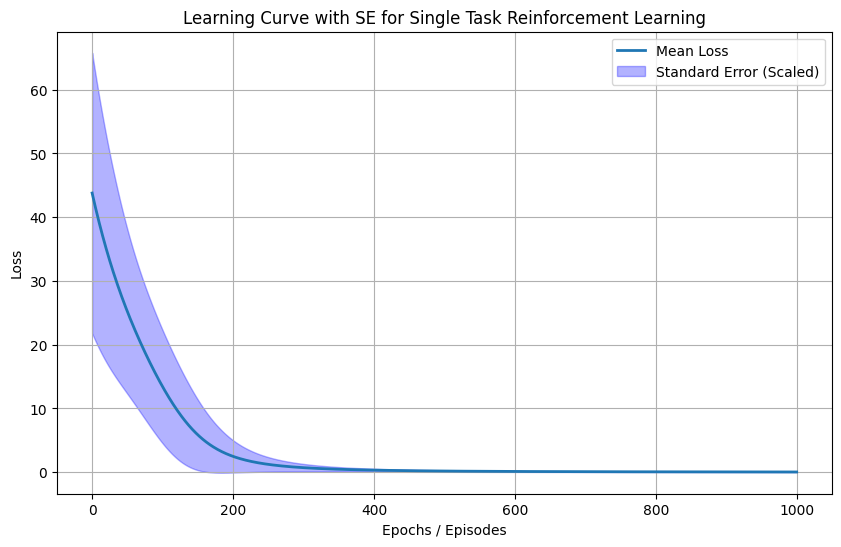

In [ ]:
plot_learning_curve_with_standard_error(mean_losses, std_err_losses, 'Learning Curve with SE for Single Task Reinforcement Learning')